# 0.0 Imports

In [13]:
import re
import os
import pickle
import inflection

import pandas            as  pd
import numpy             as  np 
import seaborn           as sns
import matplotlib.pyplot as plt

from boruta             import BorutaPy

from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso 
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [25]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/ y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])
 

## 0.2 Loading data

### Dict of data

city: Cidade em que se localiza o imovel 

area: m² do imovel

rooms: Quantidade de salas

bathroom: Quantidade de banheiros

parking spaces: Se possui vaga de garagem

floor: Andar em que o apto se encontra

animal: Se aceita ou não animal

furniture: Mobiliado ou não

hoa (R$): Valor do condominio

rent amount (R$): Valor do aluguel

property tax (R$): Valor do IPTU

fire insurance (R$): Valor do Seguro contra Incendio

total (R$): Somatoria do valor do Condominio + aluguel + IPTU + Seguro contra incendio

In [2]:
path = "../data/"
df_raw = pd.read_csv(path + "/raw/house_data.csv", sep = ",")

In [266]:
df_raw.sample()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
10064,São Paulo,98,2,2,0,8,acept,not furnished,600,4500,0,58,5158


In [3]:
#Will not use columns fire insurance (R$) and total (R$)
df_raw.drop(columns= ["fire insurance (R$)", "total (R$)"], inplace = True)
df_raw.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25


# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [323]:
df1.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)'],
      dtype='object')

In [5]:
cols_new = ['city','area','rooms','bathroom','parking_spaces','floor',
'animal','furniture','hoa','rent_amount',
'property_tax']

In [6]:
df1.columns = cols_new
df1.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking_spaces', 'floor',
       'animal', 'furniture', 'hoa', 'rent_amount', 'property_tax'],
      dtype='object')

## 1.2. Data Dimensions

In [326]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 10692
Number of Columns: 11


## 1.3. Data Types

In [327]:
df1.dtypes

city              object
area               int64
rooms              int64
bathroom           int64
parking_spaces     int64
floor             object
animal            object
furniture         object
hoa                int64
rent_amount        int64
property_tax       int64
dtype: object

## 1.4. Check NA

In [328]:
df1.isnull().sum()

city              0
area              0
rooms             0
bathroom          0
parking_spaces    0
floor             0
animal            0
furniture         0
hoa               0
rent_amount       0
property_tax      0
dtype: int64

## 1.5. Check Unique Values

In [329]:
df1.nunique()

city                 5
area               517
rooms               11
bathroom            10
parking_spaces      11
floor               35
animal               2
furniture            2
hoa               1679
rent_amount       1195
property_tax      1243
dtype: int64

## 1.6. Cleaning Data

In [7]:
num_attributes = df1.select_dtypes(include = ["int64"])
cat_attributes = df1.select_dtypes(exclude = ["int64"])

In [331]:
# Check Categorical Variables
for column in cat_attributes:

    check_cat = df1[column].value_counts(normalize=True) * 100

    print(column, '\n', check_cat, '\n')

city 
 São Paulo         55.059858
Rio de Janeiro    14.038533
Belo Horizonte    11.765806
Porto Alegre      11.157875
Campinas           7.977927
Name: city, dtype: float64 

floor 
 -      23.017209
1      10.110363
2       9.212495
3       8.707445
4       6.995885
5       5.611672
6       5.041152
7       4.648335
8       4.582866
9       3.451178
10      3.338945
11      2.833895
12      2.403666
13      1.870557
14      1.589974
15      1.374860
16      1.019454
17      0.897868
18      0.701459
19      0.495698
20      0.411523
21      0.392817
25      0.233820
23      0.233820
22      0.224467
26      0.187056
24      0.177703
27      0.074822
28      0.056117
29      0.046764
32      0.018706
35      0.009353
46      0.009353
301     0.009353
51      0.009353
Name: floor, dtype: float64 

animal 
 acept        77.777778
not acept    22.222222
Name: animal, dtype: float64 

furniture 
 not furnished    75.626637
furnished        24.373363
Name: furniture, dtype: float64 



In [8]:
# Fixing column floor
df1.iloc[2562, 5] = 30

df1['floor'] = df1['floor'].apply(lambda x: 0 if x == '-' else x)

df1['floor'] = pd.to_numeric(df1['floor'])


In [9]:
num_attributes1 = df1.select_dtypes(include = ["int64"])
cat_attributes1 = df1.select_dtypes(exclude = ["int64"])

In [10]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes1.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes1.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes1.apply(np.std)).T
d2 = pd.DataFrame(num_attributes1.apply(min)).T
d3 = pd.DataFrame(num_attributes1.apply(max)).T
d4 = pd.DataFrame(num_attributes1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes1.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ["attributes","min","max","range","mean","median","std","skew","kurtosis"]

In [335]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,area,11.0,46335.0,46324.0,149.217920,90.0,536.991829,69.596804,5548.308334
1,rooms,1.0,13.0,12.0,2.506079,2.0,1.171211,0.702391,1.487659
2,bathroom,1.0,10.0,9.0,2.236813,2.0,1.407132,1.213810,1.134852
3,parking_spaces,0.0,12.0,12.0,1.609147,1.0,1.589446,1.487534,2.769075
4,floor,0.0,51.0,51.0,5.042649,3.0,5.356925,1.435172,2.544460
5,hoa,0.0,1117000.0,1117000.0,1174.021698,560.0,15591.576074,69.039381,4912.249106
6,rent_amount,450.0,45000.0,44550.0,3896.247194,2661.0,3408.386117,1.838877,4.624228
7,property_tax,0.0,313700.0,313700.0,366.704358,125.0,3107.686983,96.013594,9667.782564


In [336]:
cat_attributes1.apply(lambda x: x.unique().shape[0])

city         5
animal       2
furniture    2
dtype: int64

## 1.7 treating outliers

In [11]:
df1.sort_values(by = 'area', ascending = False).head(7)

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax
2397,Belo Horizonte,46335,4,8,5,11,acept,furnished,960,8500,646
5915,São Paulo,24606,5,4,4,12,acept,not furnished,2254,8100,7859
9241,Campinas,12732,3,2,0,3,acept,not furnished,700,1600,96
8790,Belo Horizonte,2000,3,3,2,2,acept,furnished,3000,5000,200
5129,Belo Horizonte,2000,4,2,3,0,acept,not furnished,0,4956,200
654,São Paulo,1600,6,6,6,0,acept,furnished,0,7600,1834
4813,São Paulo,1600,4,5,12,0,acept,not furnished,1,6900,5000


In [12]:
# Change outliers area, hoa and property_tax variables to median
area_outlier1 = df1['area'] > 30000
df1.loc[area_outlier1, 'area'] = 4633
area_outlier2 = df1['area'] > 20000
df1.loc[area_outlier2, 'area'] = 2460
area_outlier3 = df1['area'] > 10000
df1.loc[area_outlier3, 'area'] = 127

hoa_outlier = df1['hoa']>220000
df1.loc[hoa_outlier, 'hoa'] = 560

property_tax_outlier = df1['property_tax'] > 30000
df1.loc[property_tax_outlier, 'property_tax'] = 125

# 2.0 EDA

In [14]:
df2 = df1.copy()

## 2.1. Numerical variables

In [397]:
num_cols = df2.columns[df2.dtypes != object]
len(num_cols)

8

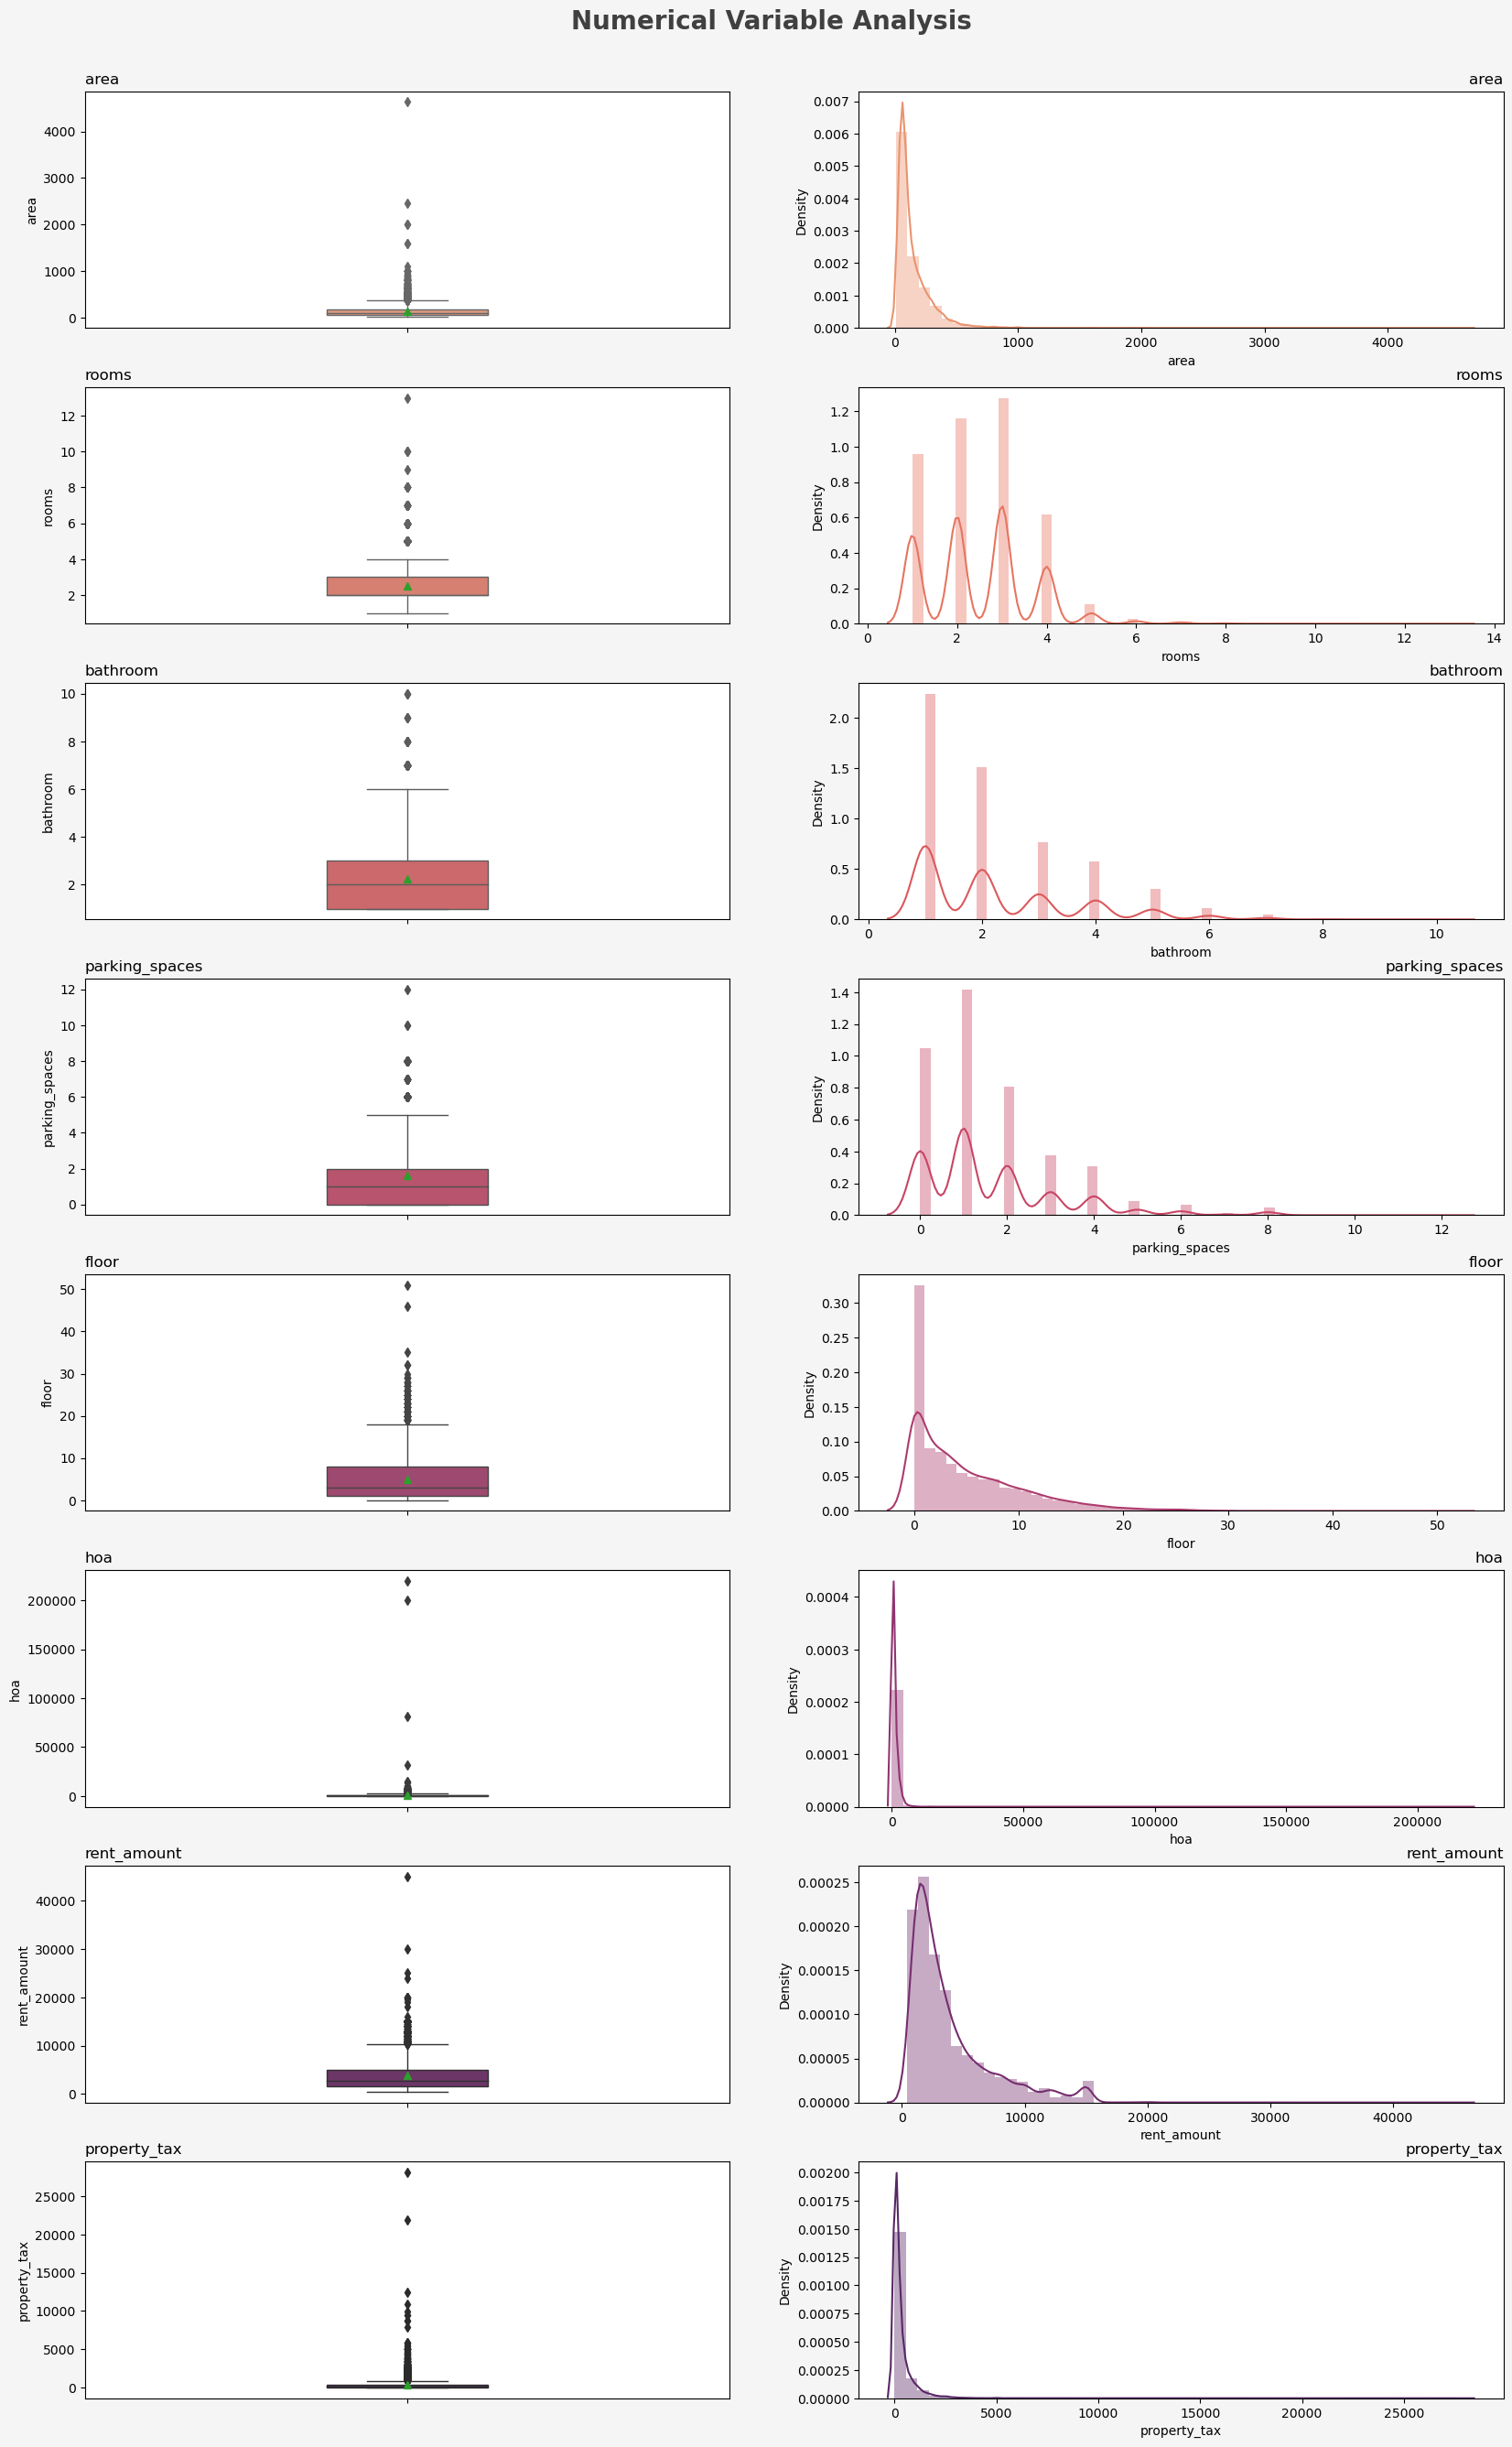

In [398]:
# size
figure, axis = plt.subplots(figsize = (20,30))

#Background
background = "#f5f5f5"
figure.set_facecolor(background)

#Color pallete
color_palette = sns.color_palette('flare', len(num_cols) * 2)

#Title
plt.suptitle("Numerical Variable Analysis", fontsize = 20, color = "#404040", fontweight = 600)

#Structure plot
lines = len(num_cols)
columns = 2
position = 1

for column in num_cols:

    #Boxplot
    plt.subplot(lines, columns, position)

    #Title
    plt.title(f'{column}', loc = 'left', fontsize = 12, fontweight = 200)

    #plot
    sns.boxplot(data = df2, y = column, showmeans = True, saturation = 0.75,
                linewidth=1, color = color_palette[position], width = 0.25)

    #change position
    position += 1

    #Distplot
    plt.subplot(lines, columns, position)

    #Title
    plt.title(f'{column}', loc = 'right', fontsize = 12, fontweight = 200)

    sns.distplot(df2[column], color = color_palette[position-1])

    #change position
    position += 1

#Adjust Grid
plt.subplots_adjust(top = .95, hspace = 0.25)

<AxesSubplot:>

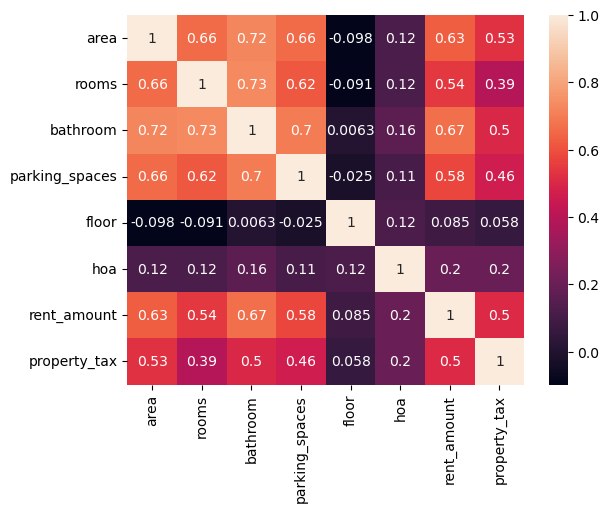

In [393]:
numerical_cols = df2.select_dtypes(exclude=['object'])
correlation = numerical_cols.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

## 2.2. Categorical Variables


In [365]:
a = df2.select_dtypes(include = ['object'])
a.head()

,city,animal,furniture
0,São Paulo,acept,furnished
1,São Paulo,acept,not furnished
2,Porto Alegre,acept,not furnished
3,Porto Alegre,acept,not furnished
4,São Paulo,not acept,not furnished


# 3.0 Data Preparation

In [15]:
df3 = df2.copy()

In [20]:
df3.to_csv('../data/interim/df3.csv', index = False)

In [21]:
df3 = pd.read_csv('../data/interim/df3.csv', sep = ",")

## 3.1. Split dataframe in train and test

In [3]:
X = df3.drop(columns = 'rent_amount', axis = 1)
y = df3['rent_amount'].copy()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

## 3.2. Normalization

Não haverá normalização dos dados pois não há nenhuma variável com distribuição normal

## 3.3. Rescaling

In [5]:
floor_rs = RobustScaler()
hoa_rs = RobustScaler()

property_tax_mms = MinMaxScaler()

# property_tax mms
X_train['property_tax'] = property_tax_mms.fit_transform(X_train[['property_tax']].values)
X_test['property_tax'] = property_tax_mms.fit_transform(X_test[['property_tax']].values)
pickle.dump(property_tax_mms, open('../models/parameter/property_max_scaler.pkl', 'wb'))


#floor rs
X_train['floor'] = floor_rs.fit_transform(X_train[['floor']].values)
X_test['floor'] = floor_rs.fit_transform(X_test[['floor']].values)
pickle.dump(floor_rs, open('../models/parameter/floor_scaler.pkl', 'wb'))

# hoa rs
X_train['hoa'] = hoa_rs.fit_transform(X_train[['hoa']].values)
X_test['hoa'] = hoa_rs.fit_transform(X_test[['hoa']].values)
pickle.dump(hoa_rs, open('../models/parameter/hoa_scaler.pkl', 'wb'))


## 3.4. Encoding

In [6]:
# City 
le = LabelEncoder()
X_train['city'] = le.fit_transform(X_train['city'])
X_test['city'] = le.fit_transform(X_test['city'])

#animal 
X_train['animal'] = X_train['animal'].apply(lambda x: 0 if  x == 'not acept' else 1)
X_test['animal'] = X_test['animal'].apply(lambda x: 0 if  x == 'not acept' else 1)

# furniture
X_train['furniture'] = X_train['furniture'].apply(lambda x: 0 if x == 'not furnished' else 1)
X_test['furniture'] = X_test['furniture'].apply(lambda x: 0 if x == 'not furnished' else 1)

In [22]:
X_train.to_csv('../data/processed/X_train.csv', sep = ",")
X_test.to_csv('../data/processed/X_test.csv', sep = ",")

y_train.to_csv('../data/processed/y_train.csv', sep = ',')
y_test.to_csv('../data/processed/y_test.csv', sep = ',')

In [ ]:
X_train = pd.read_csv('../data/processed/X_train.csv', sep = ",")
X_test = pd.read_csv("../data/processed/y_test.csv", sep = ',')
y_train = pd.read_csv("../data/processed/y_train.csv", sep = ",")
y_test = pd.read_csv("../data/processed/y_test.csv", sep = ",")

# 4.0 Feature Selection

### 4.1.1. Boruta as Feature Selector

In [7]:
# Training dataset to Boruta
X_boruta = X_train.values
y_boruta = y_train.values.ravel()

# Define RandomForest Regressor
rf = RandomForestRegressor( n_jobs = -1)

# Define Boruta
boruta = BorutaPy(rf, n_estimators = "auto", verbose = 2, random_state = 21).fit(X_boruta, y_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	7


### 4.1.2. Best Predicts from Boruta  

In [8]:
cols_selected = boruta.support_.tolist()

In [10]:
cols_selected = X_train.iloc[:, cols_selected].columns.to_list()

In [11]:
cols_selected

['area', 'hoa', 'property_tax']

In [ ]:
cols_selected_boruta = ['area', 'hoa', 'property_tax']

## 4.3. Feature Importance

In [14]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
importance = rf.feature_importances_

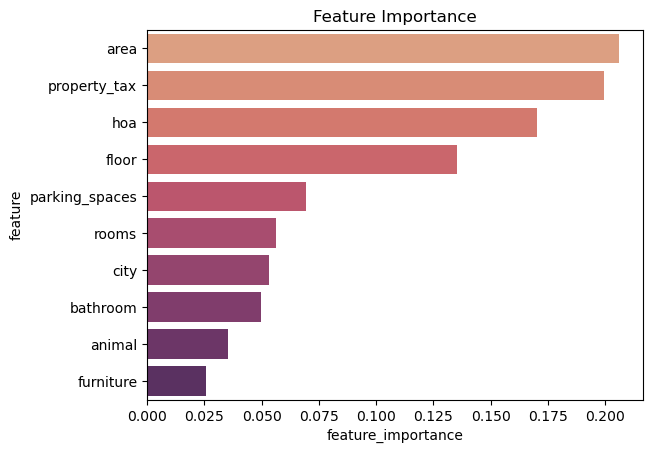

In [18]:
for i,v in enumerate(importance):
    ('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
feature_importance = pd.DataFrame({'feature':X_train.columns,
                                  'feature_importance':importance}).sort_values('feature_importance', ascending=False).reset_index()

sns.barplot(x='feature_importance', y='feature', data=feature_importance, orient='h', palette='flare').set_title('Feature Importance');

### The variables area, property_tax, hoa are selected from Boruta as RF Classifier.
### I'm select too variables floor, parking_spaces, rooms and city. 

In [23]:
X_train.sample()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,property_tax
707,1,230,4,4,8,-0.428571,1,0,-0.521127,0.01138


In [24]:
cols_selected_final = ['area', 'hoa', 'property_tax', 'floor', 'parking_spaces', 'rooms', 'city']

# 5.0 Machine Learning Modelling

In [ ]:
x_train = X_train[cols_selected_final]
x_test = X_test[cols_selected_final]



In [34]:
aux1.iloc[[0]]

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,property_tax,prediction
2249,2,60,2,1,0,-0.285714,1,0,-0.426214,0.00336,980


## 5.1. Average Model

In [42]:
aux1 = X_test.copy()
aux1['rent_amount'] = y_test.copy()
aux1['property'] = aux1.index

# Prediciton
aux2 = aux1[['property', 'rent_amount']].groupby('property').mean().reset_index().rename(columns = {'rent_amount': 'prediction'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'property')
yhat_baseline = aux1['prediction']

# performance
#baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
#baseline_result

In [ ]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/ y))


# 8.0 Hyperparameter Fine Tuning

# 9.0 Translation and Interpretration Error